<a href="https://colab.research.google.com/github/FnSK4R17s/lesions_classification/blob/master/lesions_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing data

In [0]:
import os
os.listdir('input/skin-cancer-mnist-ham10000')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [0]:
import pandas as pd
df = pd.read_csv('input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [0]:
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [0]:
def find_img(filename):
    path = 'input/skin-cancer-mnist-ham10000/'
    path1 = path+"HAM10000_images_part_1/"+filename+".jpg"
    path2 = path+"HAM10000_images_part_2/"+filename+".jpg"
    if os.path.isfile(path1):
        return path1
    elif os.path.isfile(path2):
        return path2
    

In [0]:
from PIL import Image
import numpy as np
def open_img(filename):
    path = find_img(filename)
#     print(path)
    img = Image.open(path).resize((150,112))
    img = np.asarray(img)
    return img

    

In [0]:
df['image'] = df['image_id'].apply(lambda img : open_img(img))

In [0]:
# df.head(10)

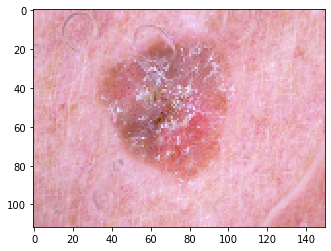

In [0]:
import matplotlib.pyplot as plt
img = df['image'][:10]
for _ in img:
    plt.imshow(_)

In [0]:
labels = df['dx'].unique()
dict_label = {}
for idx, name in enumerate(labels):
    dict_label[name] = idx
print(dict_label)   

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


In [0]:
df['label'] = df['dx'].apply(lambda dx : dict_label[dx])

In [0]:
# df.head(10)

In [0]:
#Counting Reoccurences
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

In [0]:
# df.head()

In [0]:
# if only 1 instance of image id present in dataset
# we split it into train test and validation set
from sklearn.model_selection import train_test_split

df_one = df[df['num_images'] == 1]
trainandval, test = train_test_split(df_one, test_size=0.2, shuffle=True, random_state=402)
original ,val = train_test_split(trainandval, test_size=0.2, shuffle=True, random_state=92)

# now we add second occurence of the data to test set
duplicate = df[df['num_images'] != 1]

train = pd.concat([original, duplicate])

print(train.shape)
print(test.shape)
print(val.shape)

(8029, 10)
(1103, 10)
(883, 10)


In [0]:
def load_imgs(images):
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    mR = np.mean(images[:, :, :, 0])
    mG = np.mean(images[:, :, :, 1])
    mB = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= mR
    images[:, :, :, 1] -= mG
    images[:, :, :, 2] -= mB
    return images
        

In [0]:
xtrain = load_imgs(list(train['image']))
xtest = load_imgs(list(test['image']))
xval = load_imgs(list(val['image']))

ytrain = train['label']
ytest = test['label']
yval = val['label']

In [0]:
# data is ready for prediction

print(np.shape(xtrain))
print(np.shape(xtest))
print(np.shape(xval))

(8029, 112, 150, 3)
(1103, 112, 150, 3)
(883, 112, 150, 3)


# Using InceptionV3 as our base model

In [0]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers

input_shape = (112, 150, 3)

num_labels = 7

base_model = InceptionV3(include_top=False, input_shape=(112, 150, 3),pooling = 'avg', weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))


# setting all the base layers to non trainable as instructed in fast.ai course
for layer in base_model.layers:
    layer.trainable = False
    

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 903       
Total params: 22,065,959
Trainable params: 263,175
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

# defining important callbacks which stop training at the right time

In [0]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = 'working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

epochs = 12 
batch_size = 64

history = model.fit(x=xtrain, y=ytrain,
                    batch_size=batch_size,
                    epochs=epochs, verbose=1,
                    validation_data=(xval, yval),
                    shuffle=True,
                    callbacks=[cb_early_stopper, cb_checkpointer])

Train on 8029 samples, validate on 883 samples
Epoch 1/12
8029/8029 [==============================] - 9s 1ms/sample - loss: 1.2075 - acc: 0.6408 - val_loss: 3.3430 - val_acc: 0.8007
Epoch 2/12
8029/8029 [==============================] - 8s 1ms/sample - loss: 1.2109 - acc: 0.6389 - val_loss: 3.3364 - val_acc: 0.8007
Epoch 3/12
8029/8029 [==============================] - 9s 1ms/sample - loss: 1.2108 - acc: 0.6384 - val_loss: 3.1813 - val_acc: 0.8007
Epoch 4/12
8029/8029 [==============================] - 8s 1ms/sample - loss: 1.2032 - acc: 0.6424 - val_loss: 2.6767 - val_acc: 0.7452
Epoch 5/12
8029/8029 [==============================] - 8s 1ms/sample - loss: 1.2062 - acc: 0.6404 - val_loss: 2.7168 - val_acc: 0.7826
Epoch 6/12
8029/8029 [==============================] - 8s 1ms/sample - loss: 1.1990 - acc: 0.6404 - val_loss: 3.2508 - val_acc: 0.8007
Epoch 7/12
8029/8029 [==============================] - 8s 1ms/sample - loss: 1.1961 - acc: 0.6389 - val_loss: 2.8524 - val_acc: 0.7758


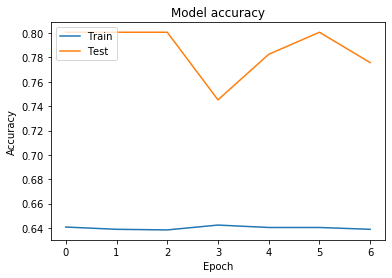

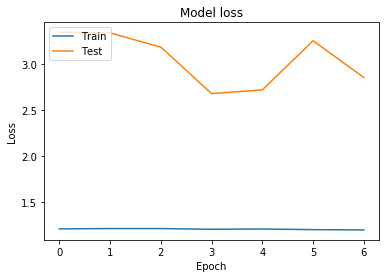

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("working/best.hdf5")
test_loss, test_acc = model.evaluate(xtest, ytest, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 1s 1ms/sample - loss: 2.5493 - acc: 0.7625
test_accuracy = 0.762466  ;  test_loss = 2.549271


In [0]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(xtrain)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(xtest)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(ytest, test_pred_classes)
confusionmatrix

array([[  0,  82,   0,   6,   0,   0,   0],
       [  0, 839,   0,  57,   0,   0,   0],
       [  0,   7,   0,   1,   0,   0,   0],
       [  0,  38,   0,   2,   0,   0,   0],
       [  0,  13,   0,   0,   0,   0,   0],
       [  0,  31,   0,   1,   0,   0,   0],
       [  0,  24,   0,   2,   0,   0,   0]], dtype=int64)

# we can see that our model overfits due to unbalanced dataset

In [0]:
from sklearn.metrics import classification_report
labels = dict_label.keys()
# Generate a classification report
#trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(ytest, test_pred_classes, target_names=list(labels))
#print(trainreport)
print(testreport)

              precision    recall  f1-score   support

         bkl       0.00      0.00      0.00        88
          nv       0.81      0.94      0.87       896
          df       0.00      0.00      0.00         8
         mel       0.03      0.05      0.04        40
        vasc       0.00      0.00      0.00        13
         bcc       0.00      0.00      0.00        32
       akiec       0.00      0.00      0.00        26

    accuracy                           0.76      1103
   macro avg       0.12      0.14      0.13      1103
weighted avg       0.66      0.76      0.71      1103



C:\Users\Shikhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# As the dataset we are using is very imbalanced we use data augmentation

In [0]:
os.mkdir('train_set')

In [0]:
dirs = train['dx'].unique()

In [0]:
for dir_ in dirs:
    os.makedirs('train_set/'+dir_)

In [0]:
os.listdir('train_set')

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image,label,num_images
1058,HAM_0007027,ISIC_0026967,bkl,consensus,75.0,female,back,"[[[196, 119, 93], [200, 124, 108], [203, 126, ...",0,1
3927,HAM_0003289,ISIC_0031357,nv,follow_up,45.0,female,abdomen,"[[[236, 154, 166], [235, 155, 168], [234, 152,...",1,1
4930,HAM_0006051,ISIC_0030475,nv,follow_up,45.0,male,lower extremity,"[[[246, 155, 160], [246, 156, 168], [246, 159,...",1,1
3613,HAM_0006339,ISIC_0031279,nv,follow_up,45.0,male,back,"[[[224, 135, 139], [225, 144, 140], [223, 146,...",1,1
8044,HAM_0002606,ISIC_0033228,nv,consensus,25.0,male,unknown,"[[[101, 62, 89], [108, 63, 94], [114, 69, 100]...",1,1


In [0]:
def save_imgs(row):
    path = 'train_set/'+row['dx']+'/'+row['image_id']+'.jpg'

    im = Image.fromarray(row['image'])
    im.save(path)


x = train.apply(save_imgs, axis=1)

In [0]:
print(len(os.listdir('train_set/nv')))
print(len(os.listdir('train_set/mel')))
print(len(os.listdir('train_set/bkl')))
print(len(os.listdir('train_set/bcc')))
print(len(os.listdir('train_set/akiec')))
print(len(os.listdir('train_set/vasc')))
print(len(os.listdir('train_set/df')))

5102
1035
945
448
273
124
102


In [0]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Copy the train images into aug_dir
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('train_set/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('train_set/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'train_set/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(112,150),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1035 images belonging to 1 classes.
Found 945 images belonging to 1 classes.
Found 448 images belonging to 1 classes.
Found 273 images belonging to 1 classes.
Found 124 images belonging to 1 classes.
Found 102 images belonging to 1 classes.


In [0]:
print(len(os.listdir('train_set/nv')))
print(len(os.listdir('train_set/mel')))
print(len(os.listdir('train_set/bkl')))
print(len(os.listdir('train_set/bcc')))
print(len(os.listdir('train_set/akiec')))
print(len(os.listdir('train_set/vasc')))
print(len(os.listdir('train_set/df')))

5102
5975
6020
6024
5510
5010
4130


In [0]:
xtraining = []
ytraining = []
def open_train_img(path):
    img = Image.open(path).resize((150,112))
    img = np.asarray(img)
    return img



for dir_ in os.listdir('train_set'):
    print(dir_)
    for image_file in os.listdir('train_set/'+dir_):
        img_path = 'train_set/'+dir_+'/'+image_file
        xtraining.append(img_path)
        ytraining.append(dict_label[dir_])

akiec
bcc
bkl
df
mel
nv
vasc


In [0]:
testing = pd.DataFrame({'features':xtraining[:],'label':ytraining[:]})

                               features  label
0      train_set/akiec/ISIC_0024372.jpg      6
1      train_set/akiec/ISIC_0024418.jpg      6
2      train_set/akiec/ISIC_0024450.jpg      6
3      train_set/akiec/ISIC_0024463.jpg      6
4      train_set/akiec/ISIC_0024468.jpg      6
5      train_set/akiec/ISIC_0024470.jpg      6
6      train_set/akiec/ISIC_0024511.jpg      6
7      train_set/akiec/ISIC_0024517.jpg      6
8      train_set/akiec/ISIC_0024522.jpg      6
9      train_set/akiec/ISIC_0024539.jpg      6
10     train_set/akiec/ISIC_0024562.jpg      6
11     train_set/akiec/ISIC_0024575.jpg      6
12     train_set/akiec/ISIC_0024579.jpg      6
13     train_set/akiec/ISIC_0024646.jpg      6
14     train_set/akiec/ISIC_0024654.jpg      6
15     train_set/akiec/ISIC_0024710.jpg      6
16     train_set/akiec/ISIC_0024763.jpg      6
17     train_set/akiec/ISIC_0024771.jpg      6
18     train_set/akiec/ISIC_0024800.jpg      6
19     train_set/akiec/ISIC_0024843.jpg      6
20     train_

In [0]:
testing = testing.sample(frac=1).reset_index(drop=True)
testing.head()

,features,label
0,train_set/bkl/_225_3381109.jpg,0
1,train_set/vasc/_3_1471170.jpg,4
2,train_set/bkl/_835_9076670.jpg,0
3,train_set/bkl/ISIC_0032463.jpg,0
4,train_set/bcc/_78_8960540.jpg,5


In [0]:
testing['features'][0]

'train_set/bkl/_225_3381109.jpg'

In [0]:
testing['features'] = testing['features'].apply(lambda img : open_train_img(img))

In [0]:
data = load_imgs(list(testing['features']))

In [0]:
np.shape(data)

(37771, 112, 150, 3)

In [0]:
train_steps = 12

In [0]:
history = model.fit(x=data, y=testing['label'],
                    validation_data=(xval, yval),
                    batch_size=batch_size,
                    epochs=train_steps, verbose=1,
                    callbacks=[cb_early_stopper, cb_checkpointer])

Train on 37771 samples, validate on 883 samples
Epoch 1/12
37771/37771 [==============================] - 88s 2ms/sample - loss: 3.0669 - acc: 0.3611 - val_loss: 11.1656 - val_acc: 0.1721
Epoch 2/12
37771/37771 [==============================] - 76s 2ms/sample - loss: 1.8006 - acc: 0.4428 - val_loss: 12.0263 - val_acc: 0.1200
Epoch 3/12
37771/37771 [==============================] - 79s 2ms/sample - loss: 1.7622 - acc: 0.4426 - val_loss: 15.6603 - val_acc: 0.0159
Epoch 4/12
37771/37771 [==============================] - 75s 2ms/sample - loss: 1.7538 - acc: 0.4421 - val_loss: 14.2048 - val_acc: 0.0294


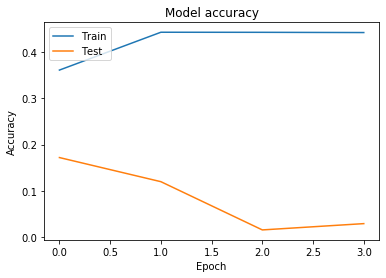

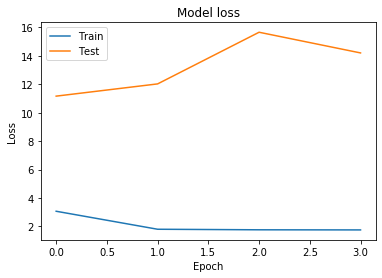

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Unfreezing base layers

In [0]:
for layer in base_model.layers:
    layer.trainable = True
    

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 903       
Total params: 297,607
Trainable params: 263,175
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(x=data, y=testing['label'],
                    validation_data=(xval, yval),
                    batch_size=batch_size,
                    epochs=train_steps, verbose=1,
                    callbacks=[cb_early_stopper, cb_checkpointer])

Train on 37771 samples, validate on 883 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/12
37771/37771 [==============================] - 166s 4ms/sample - loss: 0.9283 - acc: 0.7242 - val_loss: 0.7566 - val_acc: 0.8222
Epoch 2/12
37771/37771 [==============================] - 153s 4ms/sample - loss: 0.6269 - acc: 0.8274 - val_loss: 0.5207 - val_acc: 0.8743
Epoch 3/12
37771/37771 [==============================] - 143s 4ms/sample - loss: 0.4959 - acc: 0.8736 - val_loss: 0.6202 - val_acc: 0.8482
Epoch 4/12
37771/37771 [==============================] - 144s 4ms/sample - loss: 0.4161 - acc: 0.9010 - val_loss: 0.5049 - val_acc: 0.8607
Epoch 5/12
37771/37771 [==============================] - 144s 4ms/sample - loss: 0.3614 - acc: 0.9200 - val_loss: 0.6969 - val_acc: 0.8381
Epoch 6/12
37771/37771 [==============================] - 142s 4ms/sample - loss: 0.3102 - acc: 0.9360 - val_loss: 0.6670 - val_acc: 0.8437
Epoch 7/12
37771/37771 [==============================] - 143s 4

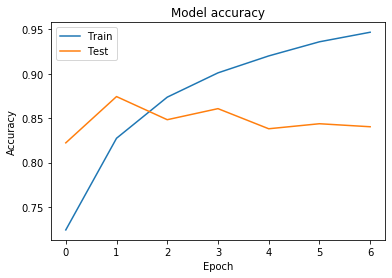

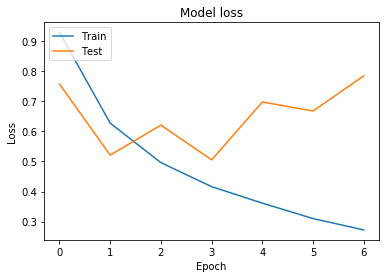

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("working/best.hdf5")
test_loss, test_acc = model.evaluate(xtest, ytest, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 4s 4ms/sample - loss: 0.5163 - acc: 0.8758
test_accuracy = 0.875793  ;  test_loss = 0.516305


In [0]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(data)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(xtest)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(ytest, test_pred_classes)
confusionmatrix

array([[ 29,  48,   1,   3,   0,   3,   4],
       [  3, 889,   0,   0,   1,   1,   2],
       [  0,   2,   6,   0,   0,   0,   0],
       [  6,  21,   1,  10,   0,   2,   0],
       [  0,   2,   0,   0,  11,   0,   0],
       [  2,  13,   0,   2,   1,  14,   0],
       [  6,   5,   0,   3,   0,   5,   7]], dtype=int64)

In [0]:
from sklearn.metrics import classification_report
labels = dict_label.keys()
# Generate a classification report
#trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(ytest, test_pred_classes, target_names=list(labels))
#print(trainreport)
print(testreport)

              precision    recall  f1-score   support

         bkl       0.63      0.33      0.43        88
          nv       0.91      0.99      0.95       896
          df       0.75      0.75      0.75         8
         mel       0.56      0.25      0.34        40
        vasc       0.85      0.85      0.85        13
         bcc       0.56      0.44      0.49        32
       akiec       0.54      0.27      0.36        26

    accuracy                           0.88      1103
   macro avg       0.68      0.55      0.60      1103
weighted avg       0.85      0.88      0.86      1103

